In [186]:
import torch
import torch.nn.functional as F
import matplotlib.pyplot as plt
%matplotlib inline

In [187]:
with open('names.txt', 'r') as f:
    words = f.read().splitlines()
words[:8]

['emma', 'olivia', 'ava', 'isabella', 'sophia', 'charlotte', 'mia', 'amelia']

In [188]:
len(words)

32033

(array([6.4000e+02, 2.9830e+03, 7.1330e+03, 1.6476e+04, 3.1080e+03,
        1.1180e+03, 5.0800e+02, 2.9000e+01, 3.0000e+01, 8.0000e+00]),
 array([ 2. ,  3.3,  4.6,  5.9,  7.2,  8.5,  9.8, 11.1, 12.4, 13.7, 15. ]),
 <BarContainer object of 10 artists>)

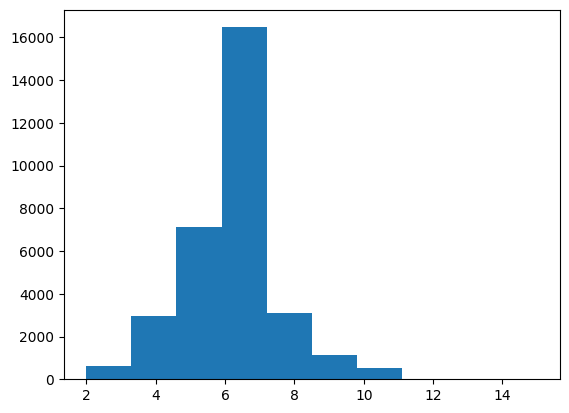

In [189]:
plt.hist([len(w) for w in words])

In [190]:
chars = sorted(list(set(''.join(words))))
stoi = {s: i+1 for i, s in enumerate(chars)}
stoi['.'] = 0
itos = {i: s for s, i in stoi.items()}

In [191]:
block_size = 3

def build_dataset(words):
    X, Y = [], []
    for w in words:
        context = [0] * block_size
        for ch in w + '.':
            ix = stoi[ch]
            X.append(context)
            Y.append(ix)
            context = context[1:] + [ix]

    X, Y = torch.tensor(X), torch.tensor(Y)
    print(X.shape, Y.shape)
    return X, Y

import random
random.seed(42)
random.shuffle(words)

n1 = int(0.8*len(words))
n2 = int(0.9*len(words))

Xtr, Ytr = build_dataset(words[:n1])
Xdev, Ydev = build_dataset(words[n1:n2])
Xte, Yte = build_dataset(words[n2:])

torch.Size([182625, 3]) torch.Size([182625])
torch.Size([22655, 3]) torch.Size([22655])
torch.Size([22866, 3]) torch.Size([22866])


In [232]:
(torch.randn(10000) * 0.2).std()

tensor(0.1998)

In [233]:
(5/3) / (30**0.5)

0.3042903097250923

In [249]:
embedding_size = 10
hl_size = 400

g = torch.Generator().manual_seed(2147483647)
C = torch.randn((27, embedding_size),                       generator=g)
W1 = torch.randn((embedding_size * block_size, hl_size),    generator=g) * (5/3) / ((embedding_size * block_size)**0.5)
# b1 = torch.randn(hl_size,                                   generator=g) * 0.01
W2 = torch.randn((hl_size, 27),                             generator=g) * 0.01
b2 = torch.randn(27,                                        generator=g) * 0

bngain = torch.ones((1, hl_size))
bnbias = torch.zeros((1, hl_size))
bnmean_running = torch.zeros((1, hl_size))
bnstd_running = torch.ones((1, hl_size))

parameters = [C, W1, b1, W2, b2, bngain, bnbias]
for p in parameters:
    p.requires_grad = True

lre = torch.linspace(-3, 0, 1000)
lrs = 10**lre

lri = []
lossi = []
stepi = []

In [250]:
@torch.no_grad()
def split_loss(split, verbose=True):
    X, Y = {
        'train': (Xtr, Ytr),
        'val': (Xdev, Ydev),
        'test': (Xte, Yte),
    }[split]

    emb = C[X]
    embcat = emb.view(-1, embedding_size * block_size)
    hpreact = embcat @ W1
    hpreact = bngain * (hpreact - hpreact.mean(0, keepdim=True)) / hpreact.std(0, keepdim=True) + bnbias
    h = torch.tanh(hpreact)
    logits = h @ W2 + b2
    loss = F.cross_entropy(logits, Y)
    if verbose:
        print(split, loss.item())
    return loss.item()

In [251]:
max_steps = 300000

for i in range(max_steps):
    # minibatching
    ix = torch.randint(0, Xtr.shape[0], (64,), generator=g)

    # forward pass
    emb = C[Xtr[ix]]
    embcat = emb.view(-1, embedding_size * block_size)
    hpreact = embcat @ W1
    # batchnorm
    bnmeani = hpreact.mean(0, keepdim=True)
    bnstdi = hpreact.std(0, keepdim=True)
    hpreact = bngain * (hpreact - bnmeani) / bnstdi + bnbias

    with torch.no_grad():
        bnmean_running = 0.999 * bnmean_running + 0.001 * bnmeani
        bnstd_running = 0.999 * bnstd_running + 0.001 * bnstdi
    
    h = torch.tanh(hpreact)
    logits = h @ W2 + b2
    loss = F.cross_entropy(logits, Ytr[ix])

    # backward pass
    for p in parameters:
        p.grad = None
    loss.backward()

    # update
    lr = 0.1 if i <= 200000 else 0.01
    for p in parameters:
        p.data += -lr * p.grad

    # track stats
    # lri.append(lre[i])
    stepi.append(i)
    lossi.append(loss.log10().item())

    if i % 10000 == 0:
        print(f'{i:7d}/{max_steps:7d}: {loss.item():.4f} (train), {split_loss('val', verbose=False):.4f} (val)')

      0/ 300000: 3.3067 (train), 3.2379 (val)
  10000/ 300000: 2.1720 (train), 2.2290 (val)
  20000/ 300000: 2.0256 (train), 2.1812 (val)
  30000/ 300000: 2.0463 (train), 2.1709 (val)
  40000/ 300000: 1.9315 (train), 2.1690 (val)
  50000/ 300000: 1.6390 (train), 2.1596 (val)
  60000/ 300000: 2.1452 (train), 2.1559 (val)
  70000/ 300000: 2.2082 (train), 2.1478 (val)
  80000/ 300000: 2.0964 (train), 2.1351 (val)
  90000/ 300000: 1.9457 (train), 2.1399 (val)
 100000/ 300000: 1.9539 (train), 2.1490 (val)
 110000/ 300000: 2.1465 (train), 2.1564 (val)
 120000/ 300000: 2.1485 (train), 2.1417 (val)
 130000/ 300000: 1.8926 (train), 2.1425 (val)
 140000/ 300000: 2.0000 (train), 2.1517 (val)
 150000/ 300000: 2.1997 (train), 2.1356 (val)
 160000/ 300000: 2.0683 (train), 2.1370 (val)
 170000/ 300000: 2.4103 (train), 2.1456 (val)
 180000/ 300000: 2.5078 (train), 2.1248 (val)
 190000/ 300000: 2.0788 (train), 2.1286 (val)
 200000/ 300000: 2.1680 (train), 2.1425 (val)
 210000/ 300000: 1.8646 (train), 2

In [253]:
@torch.no_grad()
def split_loss(split, verbose=True):
    X, Y = {
        'train': (Xtr, Ytr),
        'val': (Xdev, Ydev),
        'test': (Xte, Yte),
    }[split]

    emb = C[X]
    embcat = emb.view(-1, embedding_size * block_size)
    hpreact = embcat @ W1
    hpreact = bngain * (hpreact - bnmean_running) / bnstd_running + bnbias
    h = torch.tanh(hpreact)
    logits = h @ W2 + b2
    loss = F.cross_entropy(logits, Y)
    if verbose:
        print(split, loss.item())
    return loss.item()

In [254]:
split_loss('train')
split_loss('val')

train 1.9867967367172241
val 2.0738539695739746


2.0738539695739746

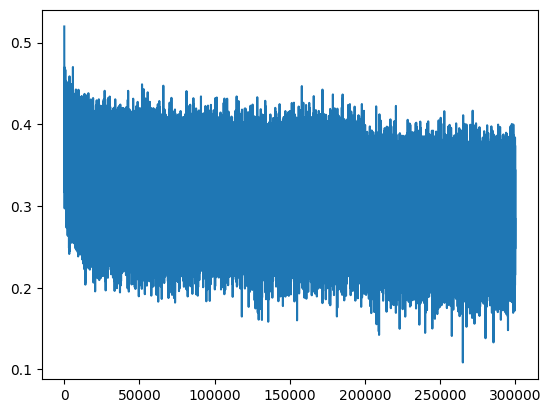

In [242]:
plt.plot(stepi, lossi)
# plt.plot(lri, lossi)

In [185]:
g = torch.Generator().manual_seed(4)

for _ in range(20):
    out = []
    context = [0] * block_size
    while True:
        emb = C[torch.tensor([context])]
        h = torch.tanh(emb.view(1, -1) @ W1 + b1)
        logits = h @ W2 + b2
        probs = F.softmax(logits, dim=1)
        ix = torch.multinomial(probs, num_samples=1, generator=g).item()
        context = context[1:] + [ix]
        out.append(ix)
        if ix == 0:
            break
    
    print(''.join(itos[i] for i in out))

bran.
jah.
lamyre.
aaraeh.
cae.
naiseylonne.
bluel.
peniyanna.
olo.
rem.
nica.
asaela.
humzhangeleigh.
lacquezeki.
kora.
joselea.
brys.
fes.
pheom.
shan.
